# Setup

In [64]:
import pandas as pd
import datetime
from wordcloud import WordCloud, STOPWORDS 
import sys
import os
import numpy as np
from PIL import Image
from textblob import TextBlob
import nltk
import re
import matplotlib
import matplotlib.pyplot as plt
import gensim
import nltk
from nltk.tokenize import word_tokenize
import pprint
import sklearn.feature_extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from nltk.stem.wordnet import WordNetLemmatizer

# Import Data

In [82]:
df = pd.read_csv("sms_scan_exit_survey.csv",keep_default_na=False) #leave blanks as blanks

###  dates take the place of subject labels
### Phrasing of question was changed after first six participants, much messier individual sequence responses for those first subjects, so I can either spend a bunch of time trying to organize that, or ignore those subjects, or just ignore individual sequences and merge across questions

In [83]:
# rename columns
df.columns = ['Subject','Q1','Q2','Q3','Q4','Q5','Q6','Q7']
# change dates to subject labels
df.Subject = range(len(df))
# merge across questions, so all responses from each subject will be in one column
df['merged'] =  df.iloc[:, 1:].sum(axis=1)

In [62]:
df.head()

,Subject,Q1,Q2,Q3,Q4,Q5,Q6,Q7,merged
0,0,,,"Yes, I thought of a singular event that the wo...",I didn't try to think of any similar events th...,"No, they were more like short segments sewed t...",,,"Yes, I thought of a singular event that the wo..."
1,1,,,2/intact - no particular event\n3/scrambled - ...,"2/intact - yes very much, as this would be a c...","3/scrambled - no, this event in my head lasted...",No,No,2/intact - no particular event\n3/scrambled - ...
2,2,,,2 scrambled no\n3 random1 no\n4 intact no\n5 s...,2 scrambled yes\n3 random1 no\n4 intact no\n5 ...,2 scrambled no\n3 random1 yes\n4 intact yes\n5...,No problems.,I think that the problems I had were there on ...,2 scrambled no\n3 random1 no\n4 intact no\n5 s...
3,3,,,no for all,"yes for 2, 5, 6, 7, 9, 12, 13, 15 and no for t...","yes for 3, 4, 16 (kind of) and no for the rest",,"2, intact -- I realized that it was a basic d...","no for allyes for 2, 5, 6, 7, 9, 12, 13, 15 an..."
4,4,,,intact - 2 - No \n\nscramble - 3 - Yes; I ...,intact - 2 - Yes. I thought of my own experi...,intact - 2 - No\n\nscramble - 3 - No\n\nran...,No,No,intact - 2 - No \n\nscramble - 3 - Yes; I ...


# Cleanup Data

In [87]:
# make everything lowercase
df['lowered'] = df.merged.apply(str.lower)
# now remove condition labels for merged condition approach
df['cleaned'] = {x.replace('intact', '').replace('scrambled', '').replace('random','') for x in df['lowered']}
# remove any numbers or non-letter characters
drop_this = re.compile('[^a-z ]', re.MULTILINE)
df['cleaned'] = {drop_this.sub(' ', x) for x in df['cleaned']}
# lemmatize 
lmtzr = WordNetLemmatizer()
# df['cleaned'] = df.cleaned.apply(lmtzr.lemmatize)
# tokenize cleaned responses
df['cleaned'] = [[lmtzr.lemmatize(w) for w in word_tokenize(text)] 
            for text in df['cleaned']]
# tokenize cleaned responses
# df['tok_merged'] = [[w.lower() for w in word_tokenize(text)] 
#             for text in df['merged']]



In [88]:
# df.head()
# print(df['merged'][23])
df['cleaned'][2]

['even',
 'though',
 'this',
 'sequence',
 'wa',
 'i',
 'played',
 'the',
 'same',
 'scene',
 'of',
 'a',
 'car',
 'crashing',
 'into',
 'a',
 'stop',
 'sign',
 'in',
 'my',
 'head',
 'whenever',
 'i',
 'wa',
 'presented',
 'this',
 'set',
 'of',
 'verb',
 'after',
 'the',
 'first',
 'two',
 'time',
 'or',
 'so',
 'i',
 'had',
 'remembered',
 'that',
 'this',
 'sequence',
 'wa',
 'and',
 'associated',
 'the',
 'car',
 'crash',
 'scene',
 'with',
 'any',
 'word',
 'in',
 'the',
 'sequence',
 'i',
 'thought',
 'of',
 'this',
 'sequence',
 'in',
 'a',
 'logical',
 'order',
 'the',
 'way',
 'i',
 'remembered',
 'it',
 'wa',
 'knowing',
 'the',
 'proper',
 'step',
 'to',
 'developing',
 'a',
 'product',
 'i',
 'had',
 'learned',
 'about',
 'the',
 'step',
 'of',
 'how',
 'a',
 'medicine',
 'get',
 'from',
 'the',
 'lab',
 'to',
 'sale',
 'in',
 'the',
 'public',
 'in',
 'a',
 'seminar',
 'based',
 'class',
 'and',
 'i',
 'applied',
 'my',
 'knowledge',
 'there',
 'to',
 'easily',
 'remember

# Look for between subject overall differences by building a tf-idf model from all subjects

Mean # of tokens: 251


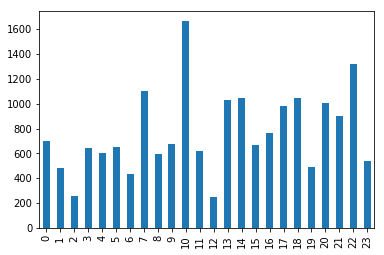

In [31]:
# plot number of tokens by subject
num_toks = df.tok_merged.apply(len)
print('Mean # of tokens:' ,np.min(num_toks))
num_toks.plot(kind = 'bar')
plt.show()

In [32]:
# create dictionary
dictionary = gensim.corpora.Dictionary(df['tok_merged'])
# see how many words in the dictionary
len(dictionary)
# I would have thought there would be more unique words... I guess that's good? 

1847

In [9]:
# create a corpus 
corpus = [dictionary.doc2bow(x) for x in df['tok_merged']]
# creat tf-idf model of the corpus
tf_idf = gensim.models.TfidfModel(corpus)
print(tf_idf)

TfidfModel(num_docs=24, num_nnz=6034)


In [10]:
# creat similarlity object with gensim
# get path
cwd = os.getcwd()
sims = gensim.similarities.Similarity(cwd,tf_idf[corpus],
                                      num_features=len(dictionary))
print(sims)

Similarity index with 24 documents in 0 shards (stored under /Users/wbr/walter/python_psc290/hw)


In [11]:
# now create a query from one sub's responses by first bag of words-ing
query_doc_bow = dictionary.doc2bow(df['tok_merged'][1])
# then index tf_idf weights
query_doc_tf_idf = tf_idf[query_doc_bow]

In [12]:
sims[query_doc_tf_idf]

array([ 0.04068984,  1.00000024,  0.15550756,  0.02335448,  0.11137828,
        0.05439073,  0.06243492,  0.05343318,  0.16747609,  0.14928679,
        0.06551225,  0.03037687,  0.00508134,  0.04148054,  0.05474997,
        0.0772889 ,  0.02482655,  0.02682976,  0.034339  ,  0.02597768,
        0.06060001,  0.02821321,  0.03432068,  0.05014485], dtype=float32)

In [13]:
sims.similarity_by_id

<bound method Similarity.similarity_by_id of <gensim.similarities.docsim.Similarity object at 0x1a1f7a6438>>

In [14]:
list(sims)[0]

array([ 0.99999899,  0.04068984,  0.0532045 ,  0.0438494 ,  0.1888521 ,
        0.07426773,  0.09896921,  0.13354322,  0.0614248 ,  0.07154027,
        0.15344808,  0.12431833,  0.07758443,  0.25103399,  0.06363554,
        0.1644273 ,  0.04082078,  0.07279146,  0.04689367,  0.0554514 ,
        0.11407172,  0.08240511,  0.08692756,  0.0948897 ], dtype=float32)

In [36]:
vect = TfidfVectorizer(min_df=1, stop_words= 'english')
tfidf = vect.fit_transform(df['cleaned'])
pairwise_similarity = tfidf * tfidf.T


In [37]:
dense_pairsim = pairwise_similarity.todense()

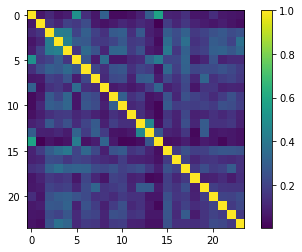

In [38]:
plt.imshow(dense_pairsim)
plt.colorbar()
plt.show()

In [39]:
# gimme two clusters
true_k = 3
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(tfidf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=3, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [40]:
# source https://stackoverflow.com/questions/27889873/clustering-text-documents-using-scikit-learn-kmeans-in-python
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vect.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i,)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print()

Top terms per cluster:
Cluster 0:
 just
 imagined
 knew
 memorized
 needed
 order
 forced
 chronological
 came
 harder

Cluster 1:
 yes
 thought
 scramble
 continuous
 generic
 words
 related
 experience
 events
 verbal

Cluster 2:
 sequence
 order
 remember
 words
 thought
 event
 scramble
 remembered
 did
 word



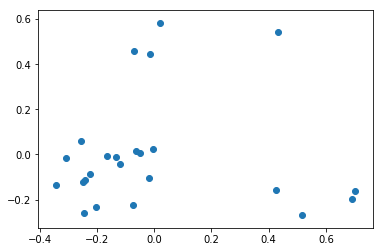

In [41]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# newsgroups_train = fetch_20newsgroups(subset='train', 
#                                       categories=['alt.atheism', 'sci.space'])
# pipeline = Pipeline([
#     ('vect', CountVectorizer()),
#     ('tfidf', TfidfTransformer()),
# ])        
# X = pipeline.fit_transform(newsgroups_train.data).todense()

X = tfidf.todense()

pca = PCA(n_components=2).fit(X)
data2D = pca.transform(X)
plt.scatter(data2D[:,0], data2D[:,1]) # c=data.target
plt.show()

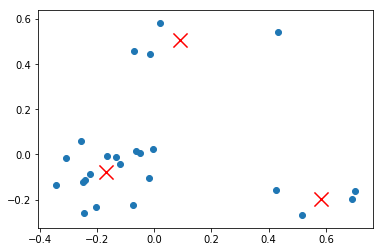

In [50]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3).fit(X)
centers2D = pca.transform(kmeans.cluster_centers_)
data2D = pca.transform(X)
plt.scatter(data2D[:,0], data2D[:,1])

plt.scatter(centers2D[:,0], centers2D[:,1], 
            marker='x', s=200, linewidths=3, c='r')
plt.show() 